## 任务描述
利用飞桨框架搭建一个Vision Transformer模型，对包含不同车辆的图像进行分类。标签值说明：1=“汽车”'，2=“摩托车”，3=“货车”

!!!!   特别提示：本实践所用数据集均来自互联网，请勿用于商务用途。

## 1. 导入相关包

In [1]:
import os
import zipfile
import random
import paddle
from paddle import fluid
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
from paddle.io import Dataset 
import numpy as np 
import sys
import paddle.nn as nn
from multiprocessing import cpu_count  
from paddle.nn import MaxPool2D,Conv2D,BatchNorm2D
from paddle.nn import Linear 
import random
from paddle.nn.initializer import TruncatedNormal, Constant 
from paddle.nn import TransformerEncoderLayer, TransformerEncoder
from paddle.regularizer import L2Decay
print("Environment OK!")

Environment OK!


## 2.配置模型参数
配置模型参数，并且设置随机数种子，确保相同参数配置时，结果可复现

In [314]:
'''
参数配置
'''
train_parameters = {
    "input_size": [3, 120, 120],                             #输入图片的shape
    "class_dim": 3,                                          #分类数
    "src_path":"/home/aistudio/data/data72920/Data.zip",     #原始数据集路径
    "target_path":"/home/aistudio/work/",                    #要解压的路径
    "train_list_path": "/home/aistudio/data/train.txt",      #train.txt路径
    "eval_list_path": "/home/aistudio/data/eval.txt",        #eval.txt路径
    "label_dict":{'0':'汽车','1':'摩托车','2':'货车'},        #标签字典
    "num_epochs": 40,                                        #训练轮数
    "train_batch_size": 32,                                   #训练时每个批次的大小
    "learning_strategy": {                                   #优化函数相关的配置
        "lr": 1.0e-5                                        #超参数学习率
    }, 
    'skip_steps': 50,                                        #每N个批次打印一次结果
    'save_steps': 500,                                       #每N个批次保存一次模型参数
    "checkpoints": "/home/aistudio/work/checkpoints"         #保存的路径

}

def seed_paddle(seed=1024):
    seed = int(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    paddle.seed(seed)

seed_paddle(seed=1024)

## 3. 数据集准备
(1)解压原始数据集

(2)按照比例划分训练集与验证集

(3)乱序，生成数据列表

(4)定义数据读取器

In [315]:
# 解压原始数据集
def unzip_data(src_path,target_path):
    '''
    解压原始数据集，将src_path路径下的zip包解压至target_path目录下
    '''
    if(not os.path.isdir(os.path.join(target_path,'Data'))):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()
        print('数据集解压完成')
    else:
        print('文件已存在')

def get_data_list(target_path, train_list_path, eval_list_path):
    '''
    生成数据列表
    '''
    data_dir = 'work/Data'
    all_data_list  = []

    for im in os.listdir(data_dir):
        img_path = os.path.join(data_dir, im)
        img_label = str(int(im.split('_')[0])-1)                  # 图片名的_前面即为标签（但是要减1从而得到0～2的gt_label）
        all_data_list.append(img_path + '\t' + img_label + '\n')


    # 对训练列表进行乱序
    random.shuffle(all_data_list)
    
    with open(train_list_path, 'a') as f1:
        with open(eval_list_path, 'a') as f2:
            for ind, img_path_label in enumerate(all_data_list):
                #划分测试集和训练集
                if ind % 10 == 0:
                    f2.write(img_path_label) 
                else:
                    f1.write(img_path_label)
    print ('生成数据列表完成！')

class dataset(Dataset):
    def __init__(self, data_path, mode='train'):
        """
        数据读取器
        :param data_path: 数据集所在路径
        :param mode: train or eval
        """
        super().__init__()
        self.data_path = data_path
        self.img_paths = []
        self.labels = []

        if mode == 'train':
            with open(os.path.join(self.data_path, "train.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))

        else:
            with open(os.path.join(self.data_path, "eval.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))


    def __getitem__(self, index):
        """
        获取一组数据
        :param index: 文件索引号
        :return:
        """
        # 第一步打开图像文件并获取label值
        img_path = self.img_paths[index]
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB') 
        img = np.array(img).astype('float32')
        img = img.transpose((2, 0, 1)) / 255
        label = self.labels[index]
        label = np.array([label], dtype="int64")
        return img, label

    def print_sample(self, index: int = 0):
        print("文件名", self.img_paths[index], "\t标签值", self.labels[index])

    def __len__(self):
        return len(self.img_paths)

#参数初始化
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']

#解压原始数据到指定路径
unzip_data(src_path,target_path)

#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate()     

#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path)

#训练数据加载
train_dataset = dataset('/home/aistudio/data',mode='train')
train_loader = paddle.io.DataLoader(train_dataset, 
                                    batch_size=train_parameters['train_batch_size'], 
                                    shuffle=True
                                    )
#测试数据加载
eval_dataset = dataset('/home/aistudio/data',mode='eval')
eval_loader = paddle.io.DataLoader(eval_dataset,
                                   batch_size=train_parameters['train_batch_size'], 
                                   shuffle=False
                                   )

文件已存在
生成数据列表完成！


## 4. 构建模型

In [316]:
# 定义ViT
trunc_normal_ = TruncatedNormal(std=.02)
zeros_ = Constant(value=0.)
ones_ = Constant(value=1.)
dim =256                                                                       # 每个patch块经过线性变换层之后的维度，对应下面的embed_dim
heads=16                                                                       # 对应Attention模块中的num_heads
patch_size = 8                                                                # 每个patch图片块的尺寸：8*8
num_layers = 1                                                               # Encoder的层数，可以先试试1层以防训练时间太长
num_patch = int((120/patch_size) * (120/patch_size))         # 图片原始尺寸为120*120

# x[int] -> tuple(x, x)
# 这是为了把变成x*x维度的patch块or图片
def to_2tuple(x):
    return tuple([x] * 2)

# 独立层，即什么操作都没有的网络层
class Identity(nn.Layer):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, input):
        return input

# 从原始图片生成patch块，并且进行Linear Proj.把特征维度变换到embed_dim
class PatchEmbed(nn.Layer):
    def __init__(self, img_size=120, patch_size=patch_size, in_chans=3, embed_dim=dim):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * \
            (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        # 关键点：利用kernel_size和stride_size都等于patch_size，来实现分块
        # 每个patch的维度（256）靠channel方向的size（=embed_dim）来实现
        # 之后拉平即可确保每个patch是B*1*256（总共num_patches个patch）
        self.proj = nn.Conv2D(in_chans, embed_dim,
                              kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        # 分块线性变换 + 向量展平 + 维度转置
        x = self.proj(x).flatten(2).transpose((0, 2, 1))
        return x

# Multi-head self-attention层：在每个Block（=1个Transformer Encode模块）中被用到
class Attention(nn.Layer):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads                        # Multi-Head中的head数，即每组q/k/v各有几个
        head_dim = dim // num_heads                      # 每一个head的特征维度
        self.scale = qk_scale or head_dim ** -0.5

        # 线性映射到dim*3之后，self.qkv可以切分为3份（如67行所示）
        # 每一份都与原来的输入x维度相同（都是dim），然后每一份中每一个head的特征维度变为dim//num_heads（如53行所示）
        self.qkv = nn.Linear(dim, dim * 3, bias_attr=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape

        # 线性变换
        qkv = self.qkv(x).reshape((B, N, 3, self.num_heads, C //
                                   self.num_heads)).transpose((2, 0, 3, 1, 4))
        
        # 分割 query key value
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Matmul + Scale：这就是self-attention机制中，k和q做attention的那一步 
        attn = (q.matmul(k.transpose((0, 1, 3, 2)))) * self.scale

        # SoftMax
        attn = nn.functional.softmax(attn, axis=-1)
        
        # Attention Dropout
        attn = self.attn_drop(attn)
        
        # Matmul
        x = (attn.matmul(v)).transpose((0, 2, 1, 3)).reshape((B, N, C))

        # 线性变换
        x = self.proj(x)

        # Linear Dropout
        x = self.proj_drop(x)
        return x

# 这是Transformer Encoder中最上面的那个MLP层（而非整个ViT中最后的分类head）
class Mlp(nn.Layer):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x): 
        x = self.fc1(x) 
        x = self.act(x) 
        x = self.drop(x) 
        x = self.fc2(x) 
        x = self.drop(x)
        return x

def drop_path(x, drop_prob=0., training=False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ...
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = paddle.to_tensor(1 - drop_prob)
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + paddle.rand(shape, dtype=x.dtype)
    random_tensor = paddle.floor(random_tensor) # binarize
    output = x.divide(keep_prob) * random_tensor
    return output


class DropPath(nn.Layer):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """

    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

# 堆叠一个Transformer Encoder：Norm -> Multi-Head self-attention -> Residual -> Norm -> MLP -> Residual
class Block(nn.Layer):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer='nn.LayerNorm', epsilon=1e-5):
        super().__init__()
        self.norm1 = eval(norm_layer)(dim, epsilon=epsilon)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else Identity()
        self.norm2 = eval(norm_layer)(dim, epsilon=epsilon)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,
                       act_layer=act_layer, drop=drop)

    def forward(self, x):
        # Norm + Attention + DropPath + Residual Connect
        x = x + self.drop_path(self.attn(self.norm1(x)))
        
        # Norm + MLP + DropPath + Residual Connect
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class VisionTransformer(nn.Layer):
    def __init__(self, img_size=120, patch_size=patch_size, in_chans=3, class_dim=train_parameters['class_dim'], embed_dim=dim, depth=num_layers,
                 num_heads=heads, mlp_ratio=4, qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer='nn.LayerNorm', epsilon=1e-5, **args):
        super().__init__()
        # class_dim是最终需要分类的类别数（这里是3）
        self.class_dim = class_dim

        # embed_dim是每个patch块经过线性变换层之后的特征维度（即进入Transformer的Encoder之前的维度）
        self.num_features = self.embed_dim = embed_dim

        # 生成patch
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        
        num_patches = self.patch_embed.num_patches

        # paddle.nn.Layer的API: https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/nn/Layer_cn.html
        # create_parameter：paddle.nn.Layer中的方法，创建的position_embeding是一组可学习的位置编码向量
        # add_parameter：也是paddle.nn.Layer中的方法，作用是添加参数实例（可学习），然后可以通过self.name访问该parameter。
        # num_patches的个数需要+1，因为多加了一个可学习的虚拟嵌入向量patch（原文模型图的0号patch）
        self.pos_embed = self.create_parameter(
            shape=(1, num_patches + 1, embed_dim), default_initializer=zeros_)
        self.add_parameter("pos_embed", self.pos_embed)
        
        # cls_token就是多添加的那个虚拟patch的嵌入向量（用于表达对各patch的响应）
        self.cls_token = self.create_parameter(
            shape=(1, 1, embed_dim), default_initializer=zeros_)
        self.add_parameter("cls_token", self.cls_token)
        
        self.pos_drop = nn.Dropout(p=drop_rate)
        dpr = [x for x in paddle.linspace(0, drop_path_rate, depth)]

        # 每一个block代表一个transformer的Encoder（这里暂时只用了一个）
        self.blocks = nn.LayerList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer, epsilon=epsilon)
            for i in range(depth)])

        self.norm = eval(norm_layer)(embed_dim, epsilon=epsilon)

        # Classifier head（即原文模型图中的MLP）
        self.head = nn.Linear(
            embed_dim, class_dim) if class_dim > 0 else Identity()

        # 这个Paddle中对于模型参数的初始化方法（https://github.com/PaddleEdu/Transformer-CV-models/blob/main/docs/utils.md）
        trunc_normal_(self.pos_embed)
        trunc_normal_(self.cls_token)
        
        # self.apply是对模型里面的其他参数使用_init_weights方法进行初始化
        self.apply(self._init_weights)
    
    # 参数初始化
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            zeros_(m.bias)
            ones_(m.weight)
    
    # 获取图像特征
    def forward_features(self, x):
        B = x.shape[0] 
        # Image Patch Embedding
        x = self.patch_embed(x) 
        # 分类 tokens
        cls_tokens = self.cls_token.expand((B, -1, -1)) 
        # 拼接 Embedding 和 分类 tokens
        x = paddle.concat((cls_tokens, x), axis=1) 
        # 加入位置嵌入 Position Embedding
        x = x + self.pos_embed 
        # Embedding Dropout
        x = self.pos_drop(x)
        # Transformer Encoder
        # 由多个基础模块组成
        for blk in self.blocks:
            x = blk(x) 
        # Norm
        x = self.norm(x) 
        # 提取分类 tokens 的输出
        return x[:, 0]
    
    def forward(self, x):
        x = paddle.reshape(x, shape=[-1, 3,120,120])
        # 获取图像特征
        x = self.forward_features(x) 
        # 图像分类 
        x = self.head(x) 
        return x

## 5. 训练模型

In [317]:
def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

epo: 1, step: 50, loss is: [0.98193216], acc is: [0.46875]
epo: 2, step: 100, loss is: [1.0491788], acc is: [0.40625]
epo: 3, step: 150, loss is: [0.988275], acc is: [0.3125]
epo: 4, step: 200, loss is: [1.0015575], acc is: [0.34375]
epo: 5, step: 250, loss is: [1.0467331], acc is: [0.375]
epo: 6, step: 300, loss is: [0.9381679], acc is: [0.6875]
epo: 7, step: 350, loss is: [0.93969584], acc is: [0.625]
epo: 8, step: 400, loss is: [0.90820897], acc is: [0.59375]
epo: 9, step: 450, loss is: [0.7469225], acc is: [0.8333333]
epo: 11, step: 500, loss is: [0.81866944], acc is: [0.625]
save model to: /home/aistudio/work/checkpoints/save_dir_500.pdparams
epo: 12, step: 550, loss is: [0.7302272], acc is: [0.6875]
epo: 13, step: 600, loss is: [0.7027515], acc is: [0.65625]
epo: 14, step: 650, loss is: [0.74921554], acc is: [0.5625]
epo: 15, step: 700, loss is: [0.66095567], acc is: [0.6875]
epo: 16, step: 750, loss is: [0.64341366], acc is: [0.75]
epo: 17, step: 800, loss is: [0.76724637], acc 

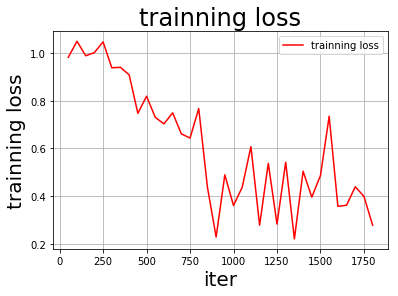

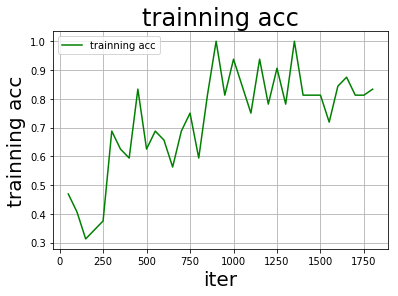

In [318]:
model = VisionTransformer()
model.train()
cross_entropy = paddle.nn.CrossEntropyLoss()
optimizer = paddle.optimizer.Adam(learning_rate=train_parameters['learning_strategy']['lr'],
                                  parameters=model.parameters()) 
                                  
steps = 0
Iters, total_loss, total_acc = [], [], []

for epo in range(train_parameters['num_epochs']):
    for _, data in enumerate(train_loader()):
        steps += 1
        x_data = data[0]
        y_data = data[1]
        predicts = model(x_data)
        loss = cross_entropy(predicts, y_data)
        acc = paddle.metric.accuracy(predicts, y_data)
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()
        if steps % train_parameters["skip_steps"] == 0:
            Iters.append(steps)
            total_loss.append(loss.numpy()[0])
            total_acc.append(acc.numpy()[0])
            #打印中间过程
            print('epo: {}, step: {}, loss is: {}, acc is: {}'\
                  .format(epo, steps, loss.numpy(), acc.numpy()))
        #保存模型参数
        if steps % train_parameters["save_steps"] == 0:
            save_path = train_parameters["checkpoints"]+"/"+"save_dir_" + str(steps) + '.pdparams'
            print('save model to: ' + save_path)
            paddle.save(model.state_dict(),save_path)
paddle.save(model.state_dict(),train_parameters["checkpoints"]+"/"+"save_dir_final.pdparams")
draw_process("trainning loss","red",Iters,total_loss,"trainning loss")
draw_process("trainning acc","green",Iters,total_acc,"trainning acc")

## 6. 评估模型

In [319]:
'''
模型评估
'''
model__state_dict = paddle.load('work/checkpoints/save_dir_final.pdparams')
model_eval = VisionTransformer()
model_eval.set_state_dict(model__state_dict) 
model_eval.eval()

accs = []
for _, data in enumerate(eval_loader()):
    x_data = data[0]
    y_data = data[1]
    predicts = model_eval(x_data)
    acc = paddle.metric.accuracy(predicts, y_data)
    accs.append(acc.numpy()[0])
print('模型在验证集上的准确率为：',np.mean(accs))

模型在验证集上的准确率为： 0.8045834
